#Step 0. Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.theta import ThetaForecaster
import warnings

In [3]:
#Step 1. Load Data
df_raw = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
df_raw

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [5]:
#Step 2. Preprocessing
df_baking = df_raw.copy()
warnings.filterwarnings("ignore")
df_baking["date"] = pd.to_datetime(
    df_baking["date"],
    yearfirst=True,format='%Y-%m-%d %H:%M:%S.%f'
)
df_baking["date"] = df_baking["date"].dt.date
df_baking["date"] = pd.to_datetime(
    df_baking["date"],
    yearfirst=True,format='%Y-%m-%d'
)
df_baking = df_baking.set_index("date")
df = df_baking['sales']
df

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633
...,...
2023-08-30,989.600354
2023-08-31,994.987326
2023-09-01,995.814415


In [6]:
#EDA
display(df.to_frame().reset_index().describe().T)

,count,mean,min,25%,50%,75%,max,std
date,366,2023-03-04 11:59:59.999999744,2022-09-03 00:00:00,2022-12-03 06:00:00,2023-03-04 12:00:00,2023-06-03 18:00:00,2023-09-03 00:00:00,NaN
sales,366.0,524.963968,53.803211,290.186822,520.699468,763.289263,1000.482785,275.089698


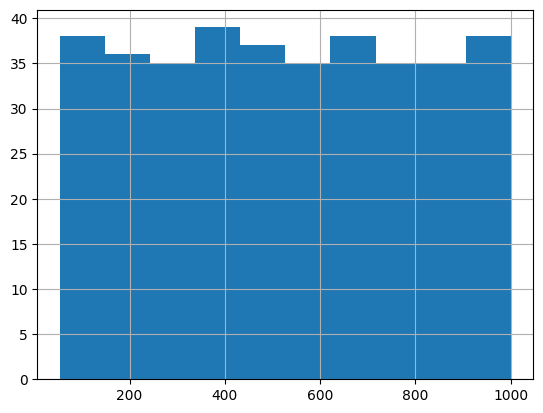

In [7]:
df.hist()
plt.show()

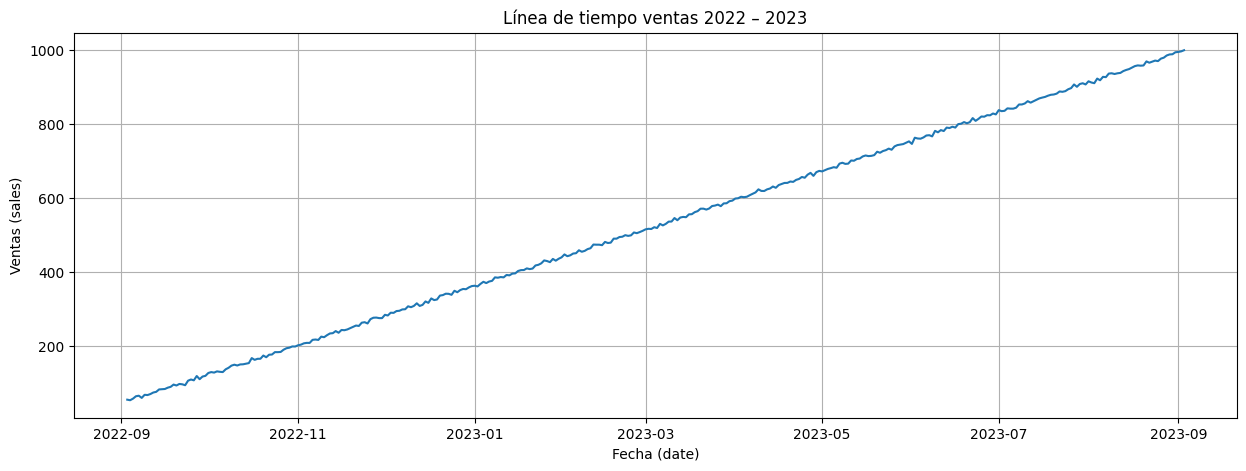

In [8]:
fig, axis = plt.subplots(figsize = (15, 5))

sns.lineplot(data=df, ax=axis)

plt.title("Línea de tiempo ventas 2022 – 2023")
plt.ylabel("Ventas (sales)")
plt.xlabel("Fecha (date)")
plt.grid(True)
plt.show()

In [9]:
df.shape

(366,)

¿Cuál es el tensor de la serie temporal?  
  - Mi tensor para la serie temporal serán los segundos, debido a que los datos de las ventas se registraron en una hora-min-seg específico del día.

¿Cuál es la tendencia?  
  - La tendencia de las ventas es ascendente. Esto significa que a medida que transcurren los meses, las ventas aumentan.   

¿Es estacionaria?  
  - No, la serie temporal no es estacionaria.  
  
¿Existe variabilidad o presencia de ruido?  
  - Si, existe una variabilidad o ruido debido a los pequeños picos que rodean la tendencia central ascendete. Lo cual es común en series de tiempo que utilizan alta frecuencia de registros en minutos y segundos

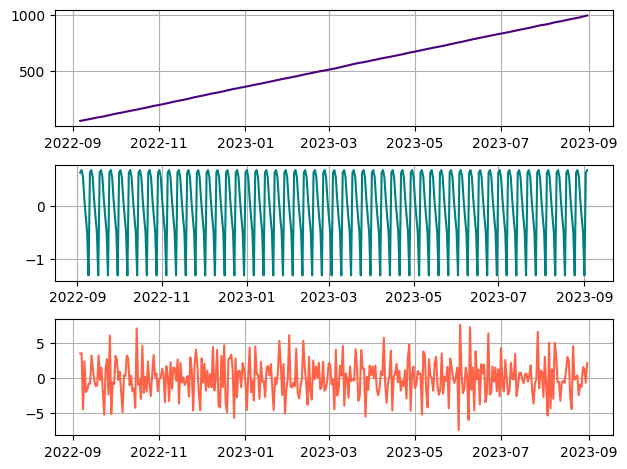

In [10]:
descomposition = seasonal_decompose(df)
trend = descomposition.trend
seasonal = descomposition.seasonal
residual = descomposition.resid

fig,ax= plt.subplots(3,1)
ax[0].plot(trend, c='indigo')
ax[0].grid(True)
ax[1].plot(seasonal, c='teal')
ax[1].grid(True)
ax[2].plot(residual, c='tomato')
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [11]:
test_dfuller= adfuller(df)
print(f'test Dickey_Fuller: {test_dfuller[0]:.2f}')
print(f'test p_value: {test_dfuller[1]:.2f}')

test Dickey_Fuller: 0.55
test p_value: 0.99


In [12]:
df_1diff = df.diff(1).dropna()
test_dfuller= adfuller(df_1diff)
print(f'test Dickey_Fuller: {test_dfuller[0]:.2f}')
print(f'test p_value: {test_dfuller[1]:.2f}')

test Dickey_Fuller: -9.43
test p_value: 0.00


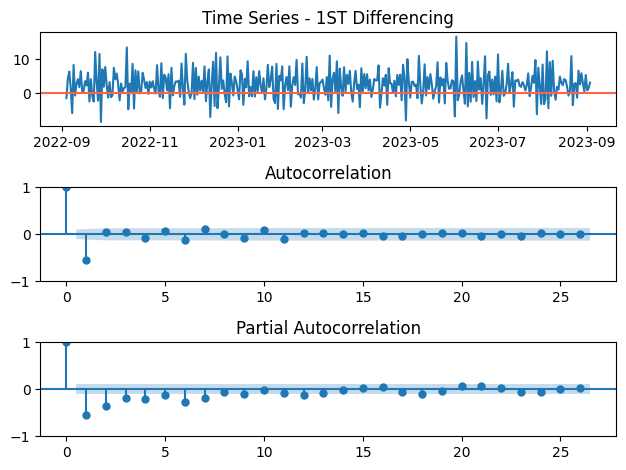

In [13]:
fig, ax =plt.subplots(3,1)
ax[0].plot(df_1diff)
ax[0].axhline(y=0,c='tomato')
ax[0].set_title('Time Series - 1ST Differencing')
plot_acf(df_1diff, ax=ax[1])
plot_pacf(df_1diff, ax=ax[2])
plt.tight_layout()
plt.show()

In [14]:
grid=[]
for p in range(5):
  for d in range(2):
    for q in range(2):
      for P in range(3):
        for D in range(3):
          for Q in range(3):
            temp_model = sm.tsa.ARIMA(df, order=(p,d,q), seasonal_order=(P,D,Q,7),
                                        enforce_invertibility=False,
                                        enforce_stationarity=False ) #Cada 7 dias se cumple el ciclo
            results = temp_model.fit()
            orders = f'{p}_{d}_{q}_{P}_{D}_{Q}'
            grid.append((orders,float(results.aic)))

In [15]:
sorted(grid, key=lambda x: x[1])[:5]

[('4_1_1_2_1_2', 1717.9107702019537),
 ('4_1_1_2_1_1', 1720.7582685991065),
 ('3_1_1_2_1_1', 1724.504254877728),
 ('3_1_1_2_1_2', 1725.9936060177222),
 ('1_1_1_0_1_2', 1727.5823527738423)]

In [18]:
model = sm.tsa.ARIMA(
    df,
    order=(4,1,1), seasonal_order=(2,1,2,7),
    enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                sales   No. Observations:                  366
Model:             ARIMA(4, 1, 1)x(2, 1, [1, 2], 7)   Log Likelihood                -848.955
Date:                              Sun, 26 Oct 2025   AIC                           1717.911
Time:                                      03:13:22   BIC                           1756.200
Sample:                                  09-03-2022   HQIC                          1733.167
                                       - 09-03-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0736      0.058     -1.279      0.201      -0.186       0.039
ar.L2          0.0394      0.061      0.642      0.521      -0.081       0.160
ar.L3          0.0660      0.054      1.226      0.220      -0.040       0.172
ar.L4         -0.0260      0.052     -0.496      0.620      -0.129       0.077
ma.L1         -0.9817      0.022    -44.931      0.000      -1.024      -0.939
ar.S.L7       -0.6072      0.156     -3.881      0.000      -0.914      -0.301
ar.S.L14       0.1370      0.057      2.418      0.016       0.026       0.248
ma.S.L7       -0.2923    239.273     -0.001      0.999    -469.258     468.674
ma.S.L14      -0.7077    169.364     -0.004      0.997    -332.655     331.240
sigma2         7.9618   1905.293      0.004      0.997   -3726.343    3742.267
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.96   Prob(JB):                         0.48
Heteroskedasticity (H):               1.09   Skew:                             0.15
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

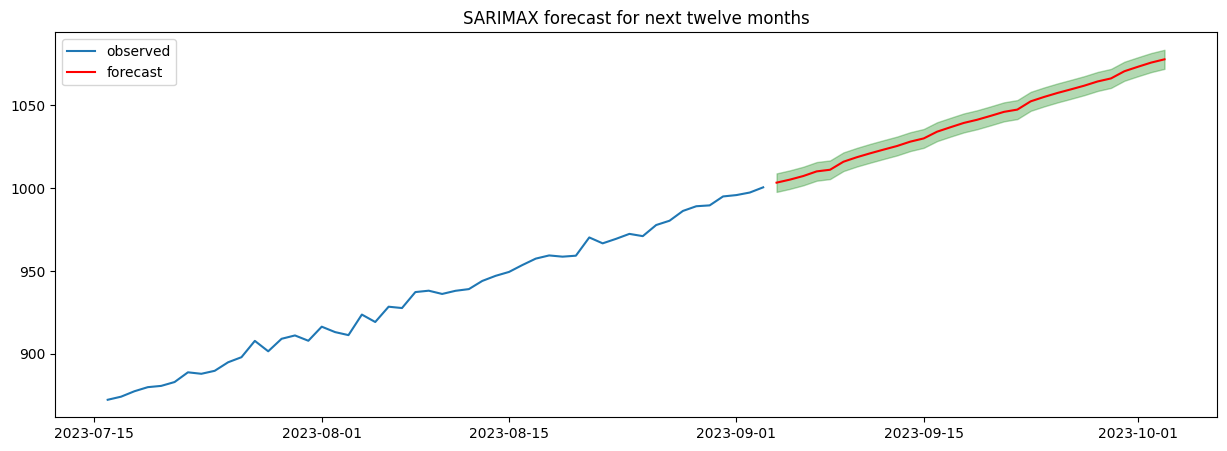

In [28]:
horizon = 30
forecast = results.get_forecast(horizon)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

fig, axis = plt.subplots(figsize = (15, 5))
plt.plot(df[-50:], label="observed")
plt.plot(forecast_mean, c="r", label="forecast")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="green", alpha=0.3)
plt.legend()
plt.title("SARIMAX forecast for next twelve months")
plt.show()

Podemos observar como se representa el intervalo de confianza. Podemos confirmar que mientras más grande sea el horizonte a predecir aumenta la incertidumbre.